# Predicting the Winrate of NBA teams

By Koushik Thiyagarajan

I am a huge NBA fan, and have been closely following the 2021-22 NBA regular season, and now the playoffs. Of course the burning question on every fan and gambler's mind when coming into a new season is: who will win this year? What players are going to be great? What teams are going to be at the top of the rankings? I decided I wanted to tackle one of these in my own way, and I chose to try and predict the winrate of an NBA team, based on their player data for that year. 

### Data Collection

For my data, I used the public site https://www.kaggle.com/datasets/nathanlauga/nba-games, which had multiple datasets containing data about NBA games, players, and teams from the 2003 season to the present season. This data goes up to games from March 12 this year. I downloaded the datasets, but only used games_details.csv and games.csv, which contain data about each player's performance in every single game, and the outcomes of each game respectively. I decided I would only use data from the 2010 season and up, to make the datasets a little smaller and quicker to process.

In [207]:
import pandas as pd
import numpy as np
import math

playerstats = pd.read_csv("archive/games_details.csv")
games = pd.read_csv("archive/games.csv")

ids = playerstats["TEAM_ID"].unique()
names = playerstats["TEAM_ABBREVIATION"].unique()
teams = pd.DataFrame(columns = ["ID", "TEAM"] ,index = range(0,30))
teams["ID"] = ids
teams["TEAM"] = names[:-4]

games = games.drop(columns=["GAME_STATUS_TEXT", "TEAM_ID_home", "TEAM_ID_away"])
games = games.drop(games.loc[games["SEASON"]<2010].index)

playerstats = playerstats.drop(columns=["PLAYER_ID", "TEAM_CITY", "START_POSITION", "NICKNAME", "PF", "FG_PCT", "FG3_PCT", "FT_PCT", "REB"])
playerstats = playerstats.drop(playerstats.loc[~pd.isnull(playerstats["COMMENT"])].index)
playerstats.dropna(subset = ["PLUS_MINUS"], inplace = True)
for row, col in games.iterrows():
    playerstats.loc[playerstats["GAME_ID"] == col["GAME_ID"], "SEASON"] = col["SEASON"]
playerstats.dropna(subset = ["SEASON"], inplace = True)
playerstats["SEASON"]= playerstats["SEASON"].astype(int)
playerstats["MIN"] = playerstats["MIN"].str.replace(":", ".")
playerstats["MIN"] = playerstats["MIN"].astype(float)

playerstats.head()

/tmp/ipykernel_93/1534991625.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  playerstats = pd.read_csv("archive/games_details.csv")


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_NAME,COMMENT,MIN,FGM,FGA,FG3M,FG3A,...,FTA,OREB,DREB,AST,STL,BLK,TO,PTS,PLUS_MINUS,SEASON
0,22101005,1610612750,MIN,Anthony Edwards,NaN,36.22,4.0,10.0,3.0,8.0,...,4.0,0.0,8.0,5.0,3.0,1.0,1.0,15.0,5.0,2021
1,22101005,1610612750,MIN,Jaden McDaniels,NaN,23.54,6.0,8.0,1.0,3.0,...,1.0,2.0,4.0,0.0,0.0,2.0,2.0,14.0,10.0,2021
2,22101005,1610612750,MIN,Karl-Anthony Towns,NaN,25.17,4.0,9.0,1.0,3.0,...,8.0,1.0,9.0,0.0,0.0,0.0,3.0,15.0,14.0,2021
3,22101005,1610612750,MIN,Malik Beasley,NaN,30.52,4.0,9.0,4.0,9.0,...,0.0,0.0,3.0,1.0,1.0,0.0,1.0,12.0,20.0,2021
4,22101005,1610612750,MIN,D'Angelo Russell,NaN,33.46,3.0,13.0,1.0,6.0,...,7.0,0.0,6.0,9.0,1.0,0.0,5.0,14.0,17.0,2021


I dropped unecessary columns for my purpose, and created a couple dataframes for which I would use later. I created a datframe for each team, and their winrates for each season, a dataframe for the stats of every player for every game in the proper seasons, and a dataframe for the game outcomes. With missing values, I noticed when looking through the csv files that a lot of data was missing from the 2003 season, in both csv files. This is part of the reason why it was dropped from the datasets. I also dropped all rows where it was indicated the player did not play that game, but was rostered on the team for it. 

### Data Management/Representation

In this next section, I fiddled with the data for it to fit my needs. First, I completed the dataset that referred to the winrate of each team for each season, from 2010-2021. Here is the code for that below:

In [208]:
winrate = pd.DataFrame(teams)
teamids = winrate["ID"].unique()
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,2021]
for tid in teamids:
    teamdata = games.loc[(games["HOME_TEAM_ID"] == tid) | (games["VISITOR_TEAM_ID"] == tid)]
    winrate.loc[winrate["ID"] == tid]
    for yr in years:
        teamyrdata = teamdata.loc[teamdata["SEASON"] == yr]
        count = len(teamyrdata.index)
        wins = len(teamyrdata.loc[((teamyrdata["HOME_TEAM_ID"] == tid) & (teamyrdata["HOME_TEAM_WINS"] == 1)) | 
                           ((teamyrdata["VISITOR_TEAM_ID"] == tid) & (teamyrdata["HOME_TEAM_WINS"] == 0))].index)
        winrate.loc[winrate["ID"] == tid, yr] = wins/count
winrate.head()

,ID,TEAM,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1610612750,MIN,0.255556,0.411765,0.397727,0.500000,0.235955,0.348315,0.404494,0.555556,0.425287,0.294118,0.337662,0.575342
1,1610612748,MIA,0.678899,0.692308,0.761062,0.654545,0.455556,0.567308,0.500000,0.516129,0.477273,0.617647,0.518987,0.666667
2,1610612739,CLE,0.280899,0.323529,0.295455,0.411111,0.657407,0.672727,0.622642,0.577982,0.244186,0.279412,0.311688,0.555556
3,1610612741,CHI,0.707547,0.729730,0.544554,0.600000,0.588235,0.511111,0.484211,0.340909,0.275862,0.342857,0.435897,0.633803
4,1610612754,IND,0.436170,0.607595,0.598131,0.633028,0.460674,0.552083,0.489130,0.576087,0.555556,0.595238,0.468354,0.347222


To create this, I parsed through the game outcomes dataset, to find all games recorded for each team for each season. Then I added the wins, and divided by the total number of games.

Next I created a dataset for each player, which calculated my personal statistic that I will use for data analysis and testing, a power score. This score is largely based on the system that ESPN has in their fantasy nba score calculator. To calculate a player's power score for a game, all of their stats including points, assists, rebounds, efficiency, and so on are given weights, and summed together to create one score, that represents a player's performance in a game. In this dataset, the average of every stat was taken and stored in lists, which were then processed through my heuristic, to create the final dataset, which had a player's average power score for a season, for every player and every season. The dataset also included the averages for all of their other stats as well. This section takes around 5 minutes to process, because of the parsing through all the player data, which is a large dataset (more than 300,000 rows). I dropped all rows for players that did not play that season. 

In [209]:
players = pd.DataFrame({"player": playerstats["PLAYER_NAME"].unique()})
cols = playerstats.columns[5:-2]
for yr in years:
    players[yr] = np.nan
players = pd.melt(players, id_vars= ["player"], value_vars = years, var_name = "season", value_name= "power")
for c in cols:
    players[c] = 0.0
players["numgames"] = 0
players["team"] = ""
players["season"] = players["season"].astype(int)
def stats(r):
    stuff = playerstats.loc[(playerstats["PLAYER_NAME"] == r["player"]) & (playerstats["SEASON"] == r["season"])]
    if len(stuff.index) > 0:
        return [r["player"], r["season"], np.nan, stuff["MIN"].sum(), stuff["FGM"].sum(), stuff["FGA"].sum(), stuff["FG3M"].sum(), stuff["FG3A"].sum(),
            stuff["FTM"].sum(), stuff["FTA"].sum(), stuff["OREB"].sum(), stuff["DREB"].sum(), stuff["AST"].sum(), stuff["STL"].sum(), stuff["BLK"].sum(),
            stuff["TO"].sum(), stuff["PTS"].sum(), len(stuff.index), stuff["TEAM_ABBREVIATION"].iloc[0]]
    else:
        return r.values.flatten().tolist()
stats = players.apply(lambda row: stats(row), axis = 1)
stats = pd.DataFrame(stats, columns = ["value"])
players = pd.DataFrame(stats['value'].to_list(), columns = players.columns)
players = players.drop(players.loc[players["numgames"] == 0].index)
cols = players.columns[3:-2]
for col in cols:
    players[col] = players[col]/players["numgames"]
players["power"] = players["PTS"] + 2.0*players["FGM"] - players["FGA"] + players["FG3M"] + players["FTM"] - 0.9*players["FTA"] +1.2*players["OREB"] + .8*players["DREB"] + 2*players["AST"] + 4*players["STL"] + 4*players["BLK"] - 2*players["TO"]
players["team"] = players["team"].apply(lambda t: "BKN" if t == "NJN" else ("NOP" if t == "NOH" else t))

players.head() 

,player,season,power,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TO,PTS,numgames,team
14,Kyle Lowry,2010,32.718667,33.993733,4.600000,10.786667,1.720000,4.573333,2.560000,3.346667,1.186667,2.933333,6.666667,1.360000,0.306667,2.106667,13.480000,75,HOU
21,Kevin Love,2010,39.020548,35.566438,6.602740,14.054795,1.205479,2.890411,5.808219,6.835616,4.520548,10.712329,2.520548,0.616438,0.383562,2.123288,20.219178,73,MIN
27,Rajon Rondo,2010,38.103896,37.097013,4.792208,10.090909,0.129870,0.597403,1.285714,2.207792,1.272727,3.220779,10.987013,2.116883,0.142857,3.467532,11.000000,77,BOS
28,Ed Davis,2010,20.901538,24.440923,3.307692,5.738462,0.000000,0.000000,1.092308,1.969231,2.584615,4.523077,0.615385,0.600000,1.030769,0.738462,7.707692,65,TOR
31,DeMar DeRozan,2010,25.100000,34.588293,6.573171,14.073171,0.060976,0.634146,3.987805,4.902439,0.914634,2.926829,1.804878,1.036585,0.378049,1.756098,17.195122,82,TOR


POWER RANKING FORMULA, weight values
PTS : 1 | 
FGM : 2 | 
FGA : (-1) | 
FG3M : 1 | 
FTM : 1 | 
FTA : (-.9) | 
OREB : 1.2 | 
DREB : 0.8 | 
AST : 2 | 
STL : 4 | 
BLK : 4 | 
TO : (-2)

### Data analysis

My goal is to try and predict a team's winrate, based on that team's power ranking for the season, which should be a good indicator of success, in theory. I created a few plots to visualize the relationship between a team's power score and its winrate, to see if there was some correlation. Below is a scatter plot of every player's average power score for each season, along with their respective team's winrate. 

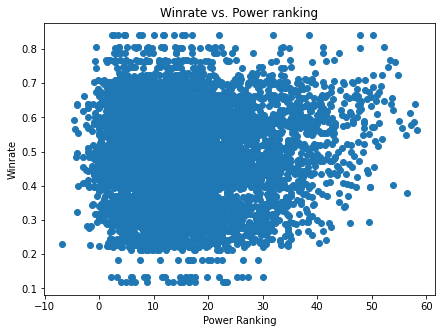

In [210]:
import matplotlib.pyplot as plt
xs = players["power"].tolist()
ys = []
for row, col in players.iterrows():
    ys.append(winrate.loc[winrate["TEAM"]==col["team"], col["season"]])
plt.figure(1, figsize=(7,5))
plt.title("Winrate vs. Power ranking")
plt.xlabel("Power Ranking")
plt.ylabel("Winrate")
plt.scatter(xs, ys)
plt.show()

This scatter plot is not very useful, since it is just a big blob of data, and does not tell us much about the relationship. This likely due to players that recieve few minutes and play few games are very numerous, and do not contribute much to a team's overall success, and as such corrupt the data some.

To fix this problem, in the next plot I cut out all players that contribute around less than half of the games played in a season, and less than half the minutes played in each game.

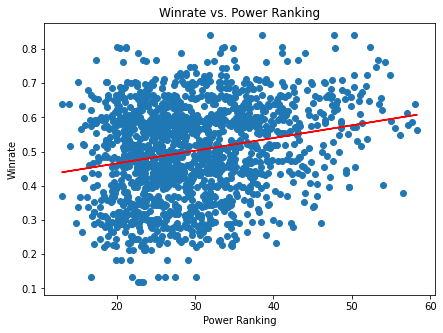

In [212]:
cutplayers = players.drop(players.loc[(players["MIN"] < 26) | (players["numgames"] < 45)].index)
xs = cutplayers["power"].tolist()
ys = []
for row, col in cutplayers.iterrows():
    ys.append(winrate.loc[winrate["TEAM"]==col["team"], col["season"]])
plt.figure(1, figsize=(7,5))
plt.title("Winrate vs. Power Ranking")
plt.scatter(xs, ys)
plt.xlabel("Power Ranking")
plt.ylabel("Winrate")
a, b = np.polyfit(xs, ys, 1)
plt.plot(xs, a*xs +b, "r-")
plt.show()

Here we see it starts to take more shape, and a trend is a little clearer, although still not very strong. I added a line fit to the graph, to see what it would look like.

These next plots, are data for each team's winrate vs their power ranking, in each separate year. The winrates and power rankings are better shown relative in their own season, since the relative power rankings are different each year. To create this, I modified the team winrate dataset, by melting, and then including a power ranking for each team each season. This power ranking was calculated by taking the mean power rankings of all the players on that team that contributed more than 20 minutes a game and 40 or more games that season.

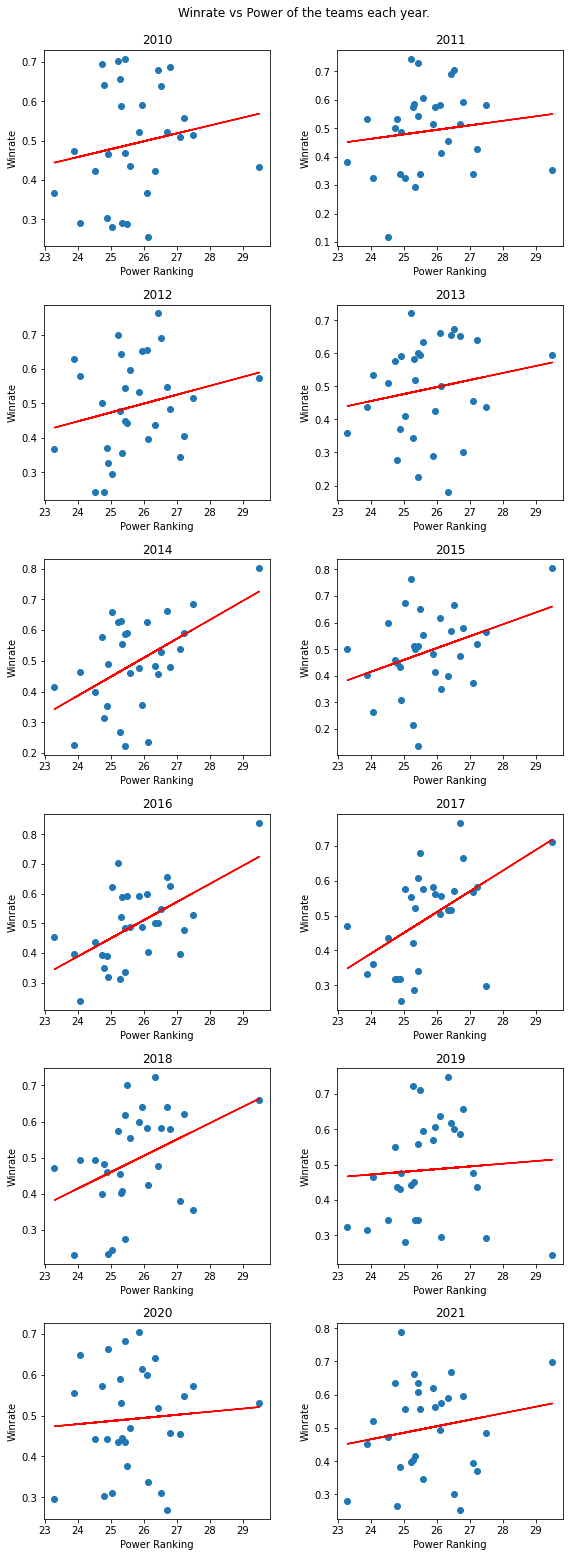

In [214]:
cutplayers = players.drop(players.loc[(players["MIN"] < 20) | (players["numgames"] < 40)].index)
teamyears = pd.melt(winrate, id_vars= ["ID", "TEAM"], value_vars = years, var_name = "season", value_name= "winrate")
teamyears["power"] = teamyears[["TEAM", "season"]].apply(lambda t: cutplayers.loc[(cutplayers["team"] == t["TEAM"]) & (cutplayers["team"] == t["TEAM"]), "power"].mean(), axis =1)
fg, ax = plt.subplots(nrows=6, ncols =2, figsize=(12,12))
col = 0
row = 0
for yr in years:
    ax[row, col].set_title(str(yr))
    byyear = teamyears.loc[teamyears["season"] == yr]
    ax[row, col].scatter(byyear["power"], byyear["winrate"])
    a, b = np.polyfit(byyear["power"], byyear["winrate"], 1)
    ax[row, col].plot(byyear["power"], a*byyear["power"] +b, "r-")
    ax[row, col].set_xlabel("Power Ranking")
    ax[row, col].set_ylabel("Winrate")
    if col == 1:
        col = 0
        row = row+1
    else:
        col+=1
fg.suptitle("Winrate vs Power of the teams each year.", x=.6,y=2.55)
plt.subplots_adjust(left=0.3,
                    bottom=.8, 
                    right=0.9, 
                    top=2.5, 
                    wspace=.3, 
                    hspace=.3)
plt.show()

Here we can see each different season, and the relationships between the power rankings and the winrates. For most of these seasons, the line fit shows to be somewhat strong, with higher slopes than in the total player plot earlier. There are a few anomalies, which are the 2020, 2019, and the 2011 seasons. These line fits have slopes very close to zero, and the data does not seem to show any relationship. This could be due to upsets, where teams do not perform as well as they should, like how in 2019 the team with the highest power ranking has the lowest winrate in the entire league. This could also be from data error.

### Hypothesis Testing

Lastly, I used a proper linear regression model with aggregate data for team power rankings and winrates every year, and tried to predict the winrate from the power ranking of the nba team, with hopefully a decent level of certainty.

In [216]:
from sklearn.linear_model import LinearRegression
test = teamyears.drop(teamyears.loc[(teamyears["season"] == 2019) | (teamyears["season"] == 2020) | (teamyears["season"] == 2011)].index)
model = LinearRegression()
xs = test["power"].to_numpy().reshape(-1, 1)
ys = test["winrate"].to_numpy()
model = model.fit(xs, ys)
print("R^2: "+ str(model.score(xs, ys)))
print("B0, y-inercept: " + str(model.intercept_) + "  B1, slope: " + str(model.coef_[0]))
err = 0
for row, col in test.iterrows():
    err += (model.predict(np.array([[col["power"]]]))[0] - col["winrate"])**2
print("sum of residuals squared: " + str(err))
print("Mean squared error: " + str(err/len(test.index)))

R^2: 0.11815524815620404
B0, y-inercept: -0.5333908657371749  B1, slope: 0.0399079849332899
sum of residuals squared: 4.668145593116692
Mean squared error: 0.017289428122654413


Here we see the R^2 value is just .118, which is very low, and indicates there is weak correlation between the power ranking and winrate of a team. The mean squared error is about 2% off of the predicted winrate, which I think is pretty substantial, considering the smaller data set size. This also does not include the data from the 2020, 2019, and 2011 seasons, which when included reduced the R^2 value. I think the low R^2 value may be due to each season being different, and the data is best compared within a season, rather than in total.

### Conclusion

In conclusion, it does not seem that my power ranking heuristic is very useful for predicting a team's success. There are many, many factors it does not account for, such as a team's playstyle, a player's weight, height, age, their season number in the nba, athelticism, defensive pressure, shot-creation, and many more. These are hard to account for, and would make the prediction a lot more accurate. There was some signs of strong correlation for the heuristic within a season, which may warrant more exploration. It would be interesting to analyze possibly a few more of these factors, and look closer at each season.